
3.0325333333## Initial import

In [31]:
## Always keep!!! Initial import
%reset -f
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import collections  as mc
import matplotlib.dates as mdates

#plt.rcParams["figure.figsize"] = [7.50, 3.50]
#plt.rcParams["figure.autolayout"] = True

#Extract CSV filling data. Each column is a different skip
skip_filling_df = pd.read_csv('../../data/raw_data/Skip-fullness-blantyre-raw.csv')

#Setting the index of the dataframe to the date and convert to datetime
skip_filling_df.set_index('date', inplace=True)
skip_filling_df.index = pd.to_datetime(skip_filling_df.index)


#Remove '.' and dates with all NaN values, convert all to float
skip_filling_df = skip_filling_df.replace('.', np.nan)
skip_filling_df = skip_filling_df.astype(float)
na_columns = skip_filling_df.sum(axis = 0)[skip_filling_df.sum(axis = 0) == 0].index.tolist()
skip_filling_df.dropna(axis=1, how='all', inplace=True)


#List of the skips
skip_dfCol = skip_filling_df.columns
#Number of columns, or skips
numSkips = len(skip_dfCol)

skip_filling_df = skip_filling_df.copy()
skip_filling_df[skip_filling_df < 8] *= 4 / 7
skip_filling_df[skip_filling_df == 8] = 5
min_plot_y = -0.5
max_plot_y = 5.5
binNum = 12 # selected bin for analysis
print(skip_dfCol)

Index(['Bangwe_Organic_1', 'Bangwe_Organic_2', 'Bangwe_inorganic_1',
       'Bangwe_inorganic_2', 'BCA_Organic_1', 'BCA_Organic_2',
       'BCA_inorganic_1', 'BCA_inorganic_2', 'Naizi_Organic_1',
       'Naizi_inorganic_1', 'Chigumula_Organic_1', 'Chigumula_Organic_2',
       'Chigumula_inorganic_1', 'Chigumula_inorganic_2'],
      dtype='object')


## Graphing functions

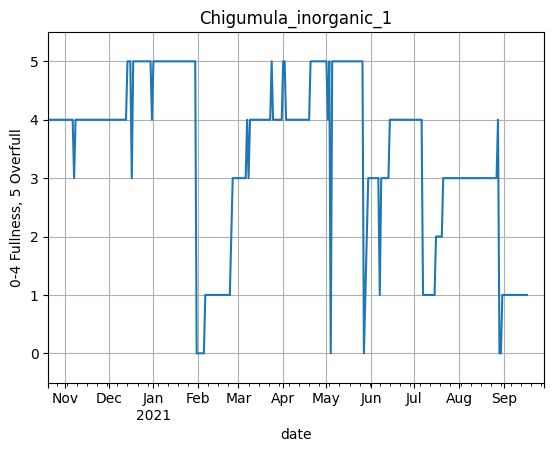

In [32]:
type_graph = 2
#binNum = 4


totY = 4
totX = 4
min_overall = skip_filling_df.index.min()
max_overall = skip_filling_df.index.max()
if type_graph == 1:
    #print(skip_filling_df[skip_dfCol[9]])
    #print(skip_filling_df.columns)
    figure, axis = plt.subplots(totX, totY)
    for i in range(totX):
        for j in range(totY):
            if j+4*i >= numSkips:
                break
            skip_filling_df.plot(ax=axis[i, j], use_index=True, y=skip_dfCol[j + 4 * i], grid=True, marker='x')
            # doesn't show missing data i.e. long straight values are as such in raw data
            axis[i, j].set_title(skip_filling_df.columns[j + 4 * i])
            axis[i, j].set_yticks([0,1,2,3,4,5])
            axis[i, j].get_legend().remove()
    plt.show()
elif type_graph == 2:
    figure, axis = plt.subplots()
    skip_filling_df.plot(ax=axis,use_index=True, y=skip_dfCol[binNum], grid=True, marker='x', markersize=0.1)
    plt.title(skip_filling_df.columns[binNum])
    plt.xlabel('date')
    plt.ylabel('0-4 Fullness, 5 Overfull')
    plt.ylim(min_plot_y,max_plot_y)
    axis.set_yticks([0,1,2,3,4,5])
    plt.xlim(min_overall,max_overall)
    
    axis.get_legend().remove()
    plt.gcf().subplots_adjust(bottom=0.15)
    plt.show()
elif type_graph == 3:
    for i in range(numSkips):
        figure, axis = plt.subplots()
        skip_filling_df.plot(ax=axis,use_index=True, y=skip_dfCol[i], grid=True, marker='x', markersize=0.1)
        plt.title(skip_filling_df.columns[i])
        plt.xlabel('date')
        plt.ylabel('0-4 Fullness, 5 Overfull')
        plt.ylim(0,5)
        axis.set_yticks([0,1,2,3,4,5])
        plt.xlim(min_overall,max_overall)
        plt.xlim(min_overall,max_overall)
        axis.get_legend().remove()
        plt.gcf().subplots_adjust(bottom=0.15)
        #plt.savefig('figures/raw/'+skip_dfCol[i]+'_raw')
        plt.close()
        #print(skip_filling_df[skip_dfCol[i]].dropna().index.min())
# try:
#     __file__
    
# except:
#     type_graph = 2
#     binNum = 3
#     plot_raw(binNum,type_graph)

## Ramp rates algo

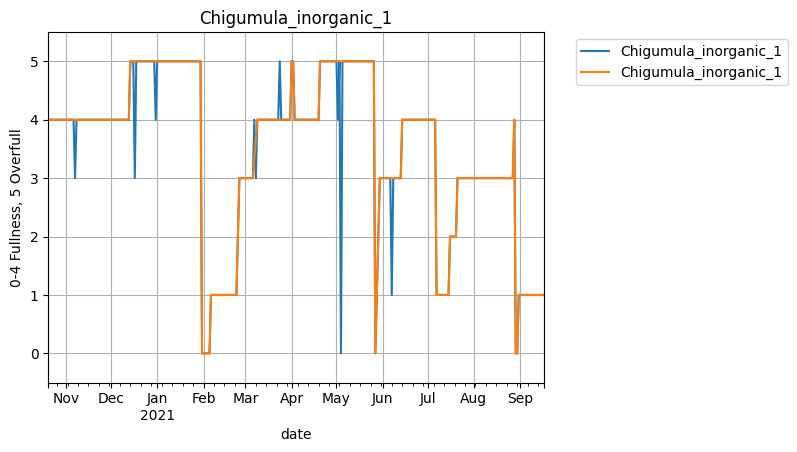

In [33]:
##########################################
## Ramp detection and profile extraction
##
## Goals: 
##     - Remove spikes
##    - Detect end of top of ramps, then beginning
##     - Remove derating increases
##     - Find start of ramps 
##########################################

skip_filling_interest = skip_filling_df[skip_dfCol[binNum]].copy().dropna() #Drops NaN from the df
diff_pos = skip_filling_interest.diff() #difference val(n) - val(n-1) #Get the difference in fullness between subsequent datapoints
diff_neg = skip_filling_interest.diff(periods=-1) #difference val(n) - val(n+1) #Get the difference in the negative direction
td_1 = pd.Timedelta(1, "d") #Define 1 days as a timedelta (pandas tool)


## Removing 1 day back to original spikes (positive and negative) Forward pass
# diff_index_pos = skip_filling_interest.index.to_series().diff() #Index difference between  points (important for NaN)
# diff_index_neg = skip_filling_interest.index.to_series().diff(periods=-1)

num_spikes_small = len((skip_filling_interest[diff_pos - diff_neg == 0][diff_pos != 0][abs(diff_pos) < 4]))
num_spikes_big = len((skip_filling_interest[diff_pos - diff_neg == 0][diff_pos != 0][abs(diff_pos) >= 4]))

skip_filling_interest_no_spike = skip_filling_interest.drop(skip_filling_interest[diff_pos - diff_neg == 0][diff_pos != 0].index)#.rename('Naizi_inorganic_1_no_spike')#[diff_index_pos == td_1][diff_index_neg == -td_1])
figure, axis = plt.subplots()

skip_filling_interest.plot(ax=axis,use_index=True, y=skip_dfCol[binNum], grid=True, marker='x', markersize=0.1)
skip_filling_interest_no_spike.plot(ax=axis,use_index=True, y=skip_dfCol[binNum], grid=True, marker='x', markersize=0.1)

plt.title(skip_filling_df.columns[binNum])
#top_ends.plot(use_index=True, grid=True, marker='*', ax = axis, linestyle='none', markersize=12)
#top_beginnings.plot(use_index=True, grid=True, marker='*', ax = axis, linestyle='none', markersize=12)
plt.xlim(skip_filling_interest.index.min(),skip_filling_interest.index.max())
axis.legend(bbox_to_anchor=(1.05, 1))
plt.title(skip_filling_df.columns[binNum])

plt.xlabel('date')
plt.ylabel('0-4 Fullness, 5 Overfull')
plt.ylim(min_plot_y,max_plot_y)
axis.set_yticks([0,1,2,3,4,5])
plt.gcf().subplots_adjust(bottom=0.15)
plt.show()


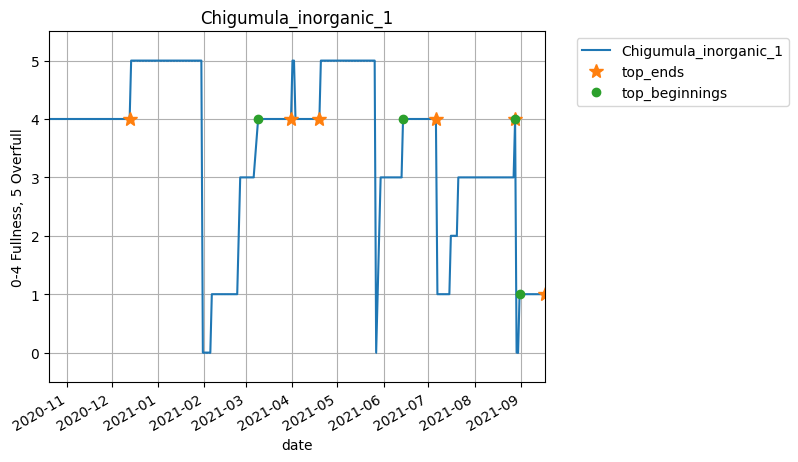

            top_beginnings
2021-08-31             1.0
2021-08-28             4.0
2021-06-14             4.0
2021-03-09             4.0


In [34]:
## Top ends - forward pass
indices_no_spike = skip_filling_interest_no_spike.index #Get indices for the current working df series

i = 0 #Counting
imax = 0 #Loop protection variable

top_ends = pd.DataFrame(columns=['top_ends']) #df with the ending of top of ramps
while i <= len(indices_no_spike) and imax < 600:
    imax = imax+1
    for j in range(len(indices_no_spike)-i-1):
        if skip_filling_interest_no_spike.loc[indices_no_spike[i+j+1]] >= skip_filling_interest_no_spike.loc[indices_no_spike[i+j]]:
            if i+j+1 == len(indices_no_spike)-1:
                top_ends.loc[indices_no_spike[i+j+1]] = skip_filling_interest_no_spike.loc[indices_no_spike[i+j+1]]
                i = i+j+1
                break
            elif skip_filling_interest_no_spike.loc[indices_no_spike[i+j]] == 4 and skip_filling_interest_no_spike.loc[indices_no_spike[i+j+1]] == 5:
                top_ends.loc[indices_no_spike[i+j]] = skip_filling_interest_no_spike.loc[indices_no_spike[i+j]]
                imax2 = 0
                while  i+j+1 <= len(indices_no_spike)-1 and skip_filling_interest_no_spike.loc[indices_no_spike[i+j+1]] == 5 and imax2 < 600:
                    imax2 = imax2+1
                    if i+j+1 <= len(indices_no_spike)-1:
                        j = j+1
                    else:
                        break
                i = i + j + 1
                break
            else:
                pass
        else:
            top_ends.loc[indices_no_spike[i+j]] = skip_filling_interest_no_spike.loc[indices_no_spike[i+j]]
            i = i+j+1
            break

## Move top ends to top beginnings, eliminates plateau from analysis. Backward pass
top_beginnings = pd.DataFrame(columns=['top_beginnings'])
i = len(top_ends)-1
imax = 0
while i >= 0 and imax < 600:
    imax = imax+1
    for j in range(indices_no_spike.get_loc(top_ends.index[i])):
        if skip_filling_interest_no_spike.loc[indices_no_spike[indices_no_spike.get_loc(top_ends.index[i])-j-1]] == skip_filling_interest_no_spike.loc[indices_no_spike[indices_no_spike.get_loc(top_ends.index[i])-j]]:
            pass
        elif skip_filling_interest_no_spike.loc[indices_no_spike[indices_no_spike.get_loc(top_ends.index[i])-j-1]] < skip_filling_interest_no_spike.loc[indices_no_spike[indices_no_spike.get_loc(top_ends.index[i])-j]]:
            top_beginnings.loc[indices_no_spike[indices_no_spike.get_loc(top_ends.index[i])-j]] = skip_filling_interest_no_spike.loc[indices_no_spike[indices_no_spike.get_loc(top_ends.index[i])-j]]
            i = i  -1
            #add to list 
            break
        else:
            i = i - 1
            break
            
figure, axis = plt.subplots()
skip_filling_interest_no_spike.plot(ax=axis,use_index=True, y=skip_dfCol[binNum], grid=True, marker='x', markersize=0.1)
plt.title(skip_filling_df.columns[binNum])
top_ends.plot(use_index=True, grid=True, marker='*', ax = axis, linestyle='none', markersize=10)
top_beginnings.plot(use_index=True, grid=True, marker='.', ax = axis, linestyle='none', markersize=12)
plt.xlim(skip_filling_interest.index.min(),skip_filling_interest.index.max())
axis.legend(bbox_to_anchor=(1.05, 1))
plt.title(skip_filling_df.columns[binNum])

plt.xlabel('date')
plt.ylabel('0-4 Fullness, 5 Overfull')
plt.ylim(min_plot_y,max_plot_y)
axis.set_yticks([0,1,2,3,4,5])
plt.gcf().subplots_adjust(bottom=0.15)

plt.show()
print(top_beginnings)

In [36]:
## Remove derating (backward pass)
top_beginnings_no_derating = top_beginnings.copy() #pd.DataFrame(columns=['top_beginnings_no_derating'])
# top_beginnings_no_derating =pd.DataFrame(columns=['top_beginnings_no_derating'])
# i = len(top_beginnings[top_beginnings==5])-1
# imax = 0
# while i >= 0 and imax < 600:
#     imax = imax+1
#     for j in range(indices_no_spike.get_loc(top_beginnings[top_beginnings==5].index[i])):
#         if skip_filling_interest_no_spike.loc[indices_no_spike[indices_no_spike.get_loc(top_beginnings[top_beginnings==5].index[i])-j-1]] == 4:
#             pass
#         elif skip_filling_interest_no_spike.loc[indices_no_spike[indices_no_spike.get_loc(top_beginnings[top_beginnings==5].index[i])-j-1]] < 4:
#             top_beginnings_no_derating.loc[indices_no_spike[indices_no_spike.get_loc(top_beginnings[top_beginnings==5].index[i])]] = skip_filling_interest_no_spike.loc[indices_no_spike[indices_no_spike.get_loc(top_beginnings[top_beginnings==5].index[i])]]
#             i = i - 1
#             #add to list 
#             break
#         else:
#             i = i - 1
#             break
            
# figure, axis = plt.subplots()
# skip_filling_interest_no_spike.plot(ax=axis,use_index=True, y=skip_dfCol[binNum], grid=True, marker='x', markersize=0.1)
# plt.title(skip_filling_df.columns[binNum])
# top_beginnings.plot(use_index=True, grid=True, marker='*', ax = axis, linestyle='none', markersize=12)
# top_beginnings_no_derating.plot(use_index=True, grid=True, marker='*', ax = axis, linestyle='none', markersize=12)
# plt.xlim(skip_filling_interest.index.min(),skip_filling_interest.index.max())
# axis.legend(bbox_to_anchor=(1.05, 1))

# plt.xlabel('date')
# plt.ylabel('0-4 Fullness, 5 Overfull')
# plt.ylim(min_plot_y,max_plot_y)
# axis.set_yticks([0,1,2,3,4,5])
# plt.gcf().subplots_adjust(bottom=0.15)

# plt.show()

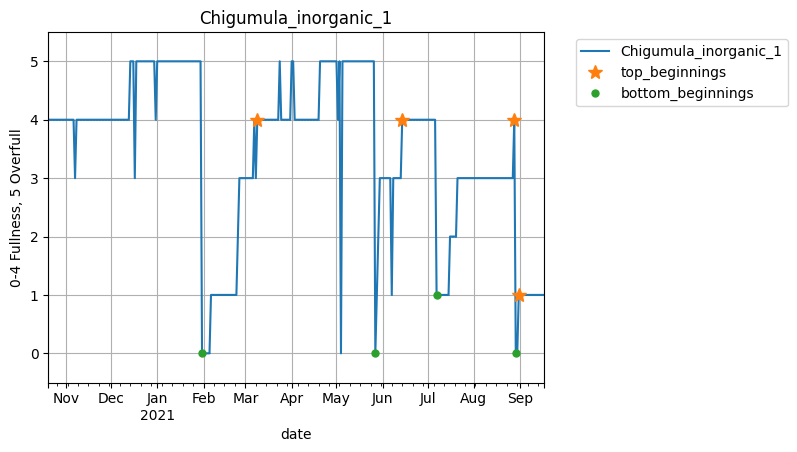

In [37]:
## Find bottoms (backward pass) walk back for as long as it decreases or equals previous
bottom_beginnings = pd.DataFrame(columns=['bottom_beginnings'])
i = len(top_beginnings_no_derating)-1
imax = 0
while i >= 0 and imax < 600:
    imax = imax+1
    for j in range(indices_no_spike.get_loc(top_beginnings_no_derating.index[i])):
        if indices_no_spike.get_loc(top_beginnings_no_derating.index[i])-j-1 == 0:
            bottom_beginnings.loc[indices_no_spike[indices_no_spike.get_loc(top_beginnings_no_derating.index[i])-j]] = skip_filling_interest_no_spike.loc[indices_no_spike[indices_no_spike.get_loc(top_beginnings_no_derating.index[i])-j]]
            i = i - 1
            break
        elif skip_filling_interest_no_spike.loc[indices_no_spike[indices_no_spike.get_loc(top_beginnings_no_derating.index[i])-j-1]] <= skip_filling_interest_no_spike.loc[indices_no_spike[indices_no_spike.get_loc(top_beginnings_no_derating.index[i])-j]]:
            pass
        else:
            bottom_beginnings.loc[indices_no_spike[indices_no_spike.get_loc(top_beginnings_no_derating.index[i])-j]] = skip_filling_interest_no_spike.loc[indices_no_spike[indices_no_spike.get_loc(top_beginnings_no_derating.index[i])-j]]
            i = i - 1
            #add to list 
            break
            
figure, axis = plt.subplots()
skip_filling_df.plot(ax=axis,use_index=True, y=skip_dfCol[binNum], grid=True, marker='x', markersize=0.1)
plt.title(skip_filling_df.columns[binNum])
top_beginnings_no_derating.plot(use_index=True, grid=True, marker='*', ax = axis, linestyle='none', markersize=10)
bottom_beginnings.plot(use_index=True, grid=True, marker='.', ax = axis, linestyle='none', markersize=10)
plt.xlim(skip_filling_interest.index.min(),skip_filling_interest.index.max())
axis.legend(bbox_to_anchor=(1.05, 1))

plt.xlabel('date')
plt.ylabel('0-4 Fullness, 5 Overfull')
plt.ylim(min_plot_y,max_plot_y)
axis.set_yticks([0,1,2,3,4,5])
plt.gcf().subplots_adjust(bottom=0.15)


plt.show()

In [38]:
#Join data
import statistics as stat
# Ordering both lists by date
top_beginnings_no_derating.sort_index(inplace = True)
bottom_beginnings.sort_index(inplace = True)

# Joining together
tops = top_beginnings_no_derating.reset_index()
tops.columns = ['index_top', 'value_top']
bottoms = bottom_beginnings.reset_index()
bottoms.columns = ['index_bottom', 'value_bottom']
POI_df = pd.concat([bottoms,tops], axis = 1)
print(np.nanmean(bottom_beginnings.index.to_series().diff().dt.days.values))

list_mc = []
for i in POI_df.values.tolist():
    tuple1 = [mdates.date2num(i[0].to_pydatetime()), i[1]]
    tuple2 = [mdates.date2num(i[2].to_pydatetime()), i[3]]
    list_mc.append([tuple1,tuple2])
#print(list_mc)
POI_df['ramp rate'] = ((POI_df.value_top-POI_df.value_bottom).astype(float)/((POI_df.index_top-POI_df.index_bottom).dt.days).astype(float))/4

70.0


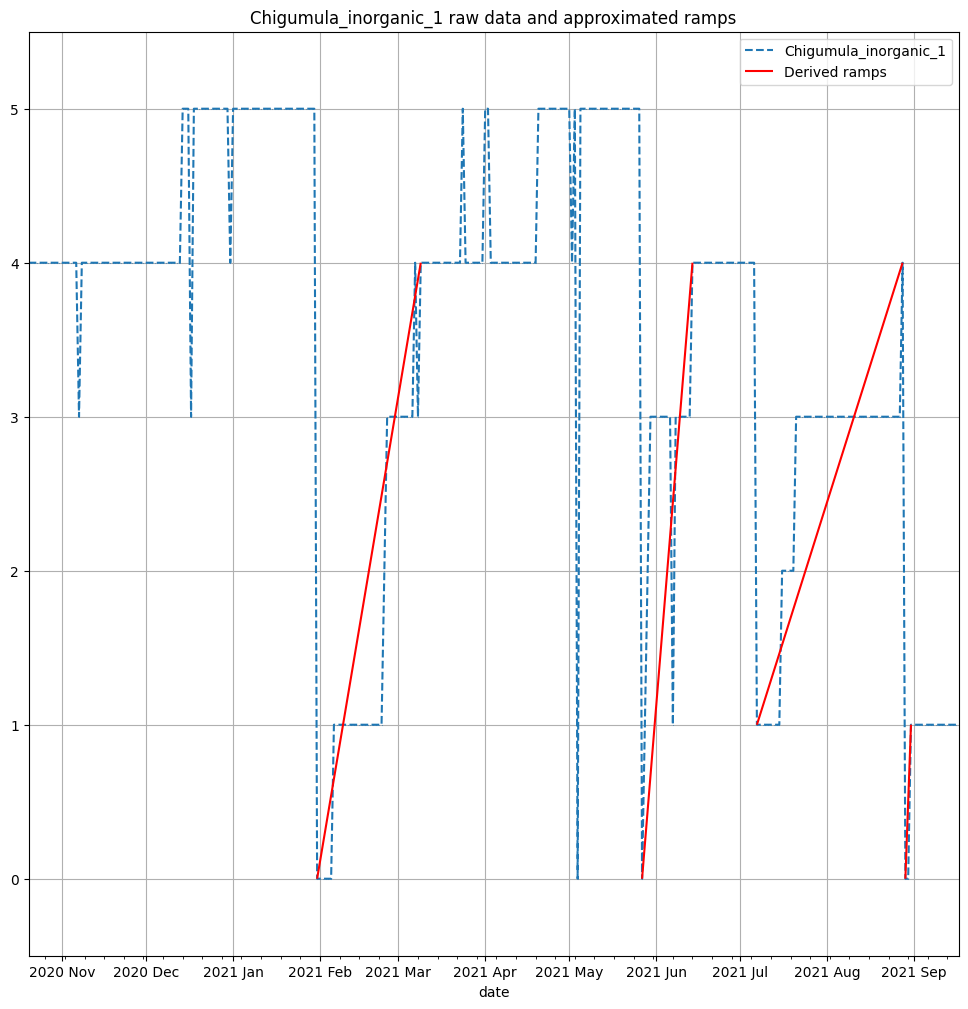

In [39]:
## Plot raw data and extracted ramps

type = 2

totY = 4
totX = 4
if type == 1:
    print(skip_filling_df[skip_dfCol[binNum]])
    #print(skip_filling_df.columns)
    figure, axis = plt.subplots(totX, totY)
    for i in range(totX):
        for j in range(totY):
            if j+4*i >= numSkips:
                break
            skip_filling_df.plot(ax=axis[i, j], use_index=True, y=skip_dfCol[j + 4 * i], grid=True, marker='x')
            # doesn't show missing data i.e. long straight values are as such in raw data
            axis[i, j].set_title(skip_filling_df.columns[j + 4 * i])
            axis[i, j].set_yticks([0,1,2,3,4,5])
            axis[i, j].get_legend().remove()
    plt.show()
elif type == 2:
    fig, ax = plt.subplots(figsize=(12,12))
    skip_filling_df.plot(ax = ax,use_index=True, y=skip_dfCol[binNum], grid=True, marker='x', markersize=0.1, linestyle="dashed")
    lc = mc.LineCollection(list_mc, color='red', label="Derived ramps")
    ax.add_collection(lc)
    plt.title(skip_filling_df.columns[binNum] + " raw data and approximated ramps")
    ax.autoscale_view()
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    monthFmt = mdates.DateFormatter("%Y %b")
    ax.xaxis.set_major_formatter(monthFmt)
    plt.xlim(skip_filling_interest.index.min(),skip_filling_interest.index.max())
    plt.ylim(min_plot_y,max_plot_y)
    axis.set_yticks([0,1,2,3,4,5])
    ax.legend()
    plt.show()

In [67]:
print(np.average(POI_df['ramp rate'].to_list()))

0.39956597222222223


## Possible interplays
- Filling rate vs dump arrival average period
- Compare two overfilling  (set as number of days @ 5 times filling rate * adjusting factor (people use the bins less when it over fills) calculations
    - Skips with filling data (days @ 5 times average filling rate)
    - All (extrapolated (or measured) rate * schedule)

## Take into consideration
- Std, Q3 and mean
- Look of weekly year bar plot

## Tasks 03/10/2022-09/10/2022
- Choose averaging function (average of ramps or weighted average?)
- Generalise ramp_rates to get df with all plots
- Couple ramp_rate and dump_deliveries
- Extrapolate to dump_deliveries
- Input into GIS

## Generalisation

In [29]:
##########################################
## Ramp detection and profile extraction
##
## Goals: 
##     - Remove spikes
##    - Detect end of top of ramps, then beginning
##     - Remove derating increases
##     - Find start of ramps 
##########################################
ramps_data = pd.DataFrame(columns =['avg_ramp','number_ramps','days_overfull_prop','number_days'])




for binNum in range(len(skip_filling_df.columns)):
    skip_filling_interest = skip_filling_df[skip_dfCol[binNum]].copy().dropna() #Drops NaN from the df
    diff_pos = skip_filling_interest.diff() #difference val(n) - val(n-1) #Get the difference in fullness between subsequent datapoints
    diff_neg = skip_filling_interest.diff(periods=-1) #difference val(n) - val(n+1) #Get the difference in the negative direction
    td_1 = pd.Timedelta(1, "d") #Define 1 days as a timedelta (pandas tool)



    #skip_filling_interest_no_spike = skip_filling_interest.copy()
    skip_filling_interest_no_spike = skip_filling_interest.drop(skip_filling_interest[diff_pos - diff_neg == 0][diff_pos != 0].index)#[diff_index_pos == td_1][diff_index_neg == -td_1])


    ## Top ends - forward pass
    indices_no_spike = skip_filling_interest_no_spike.index #Get indices for the current working df series

    i = 0 #Counting
    imax = 0 #Loop protection variable

    top_ends = pd.DataFrame(columns=['top_ends']) #df with the ending of top of ramps
    while i <= len(indices_no_spike) and imax < 600:
        imax = imax+1
        for j in range(len(indices_no_spike)-i-1):
            if skip_filling_interest_no_spike.loc[indices_no_spike[i+j+1]] >= skip_filling_interest_no_spike.loc[indices_no_spike[i+j]]:
                if i+j+1 == len(indices_no_spike)-1:
                    top_ends.loc[indices_no_spike[i+j+1]] = skip_filling_interest_no_spike.loc[indices_no_spike[i+j+1]]
                    i = i+j+1
                    break
                elif skip_filling_interest_no_spike.loc[indices_no_spike[i+j]] == 4 and skip_filling_interest_no_spike.loc[indices_no_spike[i+j+1]] == 5:
                    top_ends.loc[indices_no_spike[i+j]] = skip_filling_interest_no_spike.loc[indices_no_spike[i+j]]
                    imax2 = 0
                    while  i+j+1 <= len(indices_no_spike)-1 and skip_filling_interest_no_spike.loc[indices_no_spike[i+j+1]] == 5 and imax2 < 600:
                        imax2 = imax2+1
                        if i+j+1 <= len(indices_no_spike)-1:
                            j = j+1
                        else:
                            break
                    i = i + j + 1
                    break
                else:
                    pass
            else:
                top_ends.loc[indices_no_spike[i+j]] = skip_filling_interest_no_spike.loc[indices_no_spike[i+j]]
                i = i+j+1
                break



    ## Move top ends to top beginnings, eliminates plateau from analysis. Backward pass
    top_beginnings = pd.DataFrame(columns=['top_beginnings'])
    i = len(top_ends)-1
    imax = 0
    while i >= 0 and imax < 600:
        imax = imax+1
        for j in range(indices_no_spike.get_loc(top_ends.index[i])):
            if skip_filling_interest_no_spike.loc[indices_no_spike[indices_no_spike.get_loc(top_ends.index[i])-j-1]] == skip_filling_interest_no_spike.loc[indices_no_spike[indices_no_spike.get_loc(top_ends.index[i])-j]]:
                pass
            elif skip_filling_interest_no_spike.loc[indices_no_spike[indices_no_spike.get_loc(top_ends.index[i])-j-1]] < skip_filling_interest_no_spike.loc[indices_no_spike[indices_no_spike.get_loc(top_ends.index[i])-j]]:
                top_beginnings.loc[indices_no_spike[indices_no_spike.get_loc(top_ends.index[i])-j]] = skip_filling_interest_no_spike.loc[indices_no_spike[indices_no_spike.get_loc(top_ends.index[i])-j]]
                i = i - 1
                #add to list 
                break
            else:
                i = i - 1
                break

    # figure, axis = plt.subplots()
    # skip_filling_interest_no_spike.plot(ax=axis,use_index=True, y=skip_dfCol[binNum], grid=True, marker='x')
    # plt.title(skip_filling_df.columns[binNum])
    # top_ends.plot(use_index=True, grid=True, marker='*', ax = axis, linestyle='none', markersize=12)
    # top_beginnings.plot(use_index=True, grid=True, marker='*', ax = axis, linestyle='none', markersize=12)
    # plt.xlim(skip_filling_interest.index.min(),skip_filling_interest.index.max())
    # axis.legend(bbox_to_anchor=(1.05, 1))
    # plt.show()


    ## Remove derating (backward pass)
    top_beginnings_no_derating = pd.DataFrame(columns=['top_beginnings_no_derating'])
    i = len(top_beginnings[top_beginnings==5])-1
    imax = 0
    while i >= 0 and imax < 600:
        imax = imax+1
        for j in range(indices_no_spike.get_loc(top_beginnings[top_beginnings==5].index[i])):
            if skip_filling_interest_no_spike.loc[indices_no_spike[indices_no_spike.get_loc(top_beginnings[top_beginnings==5].index[i])-j-1]] == 4:
                pass
            elif skip_filling_interest_no_spike.loc[indices_no_spike[indices_no_spike.get_loc(top_beginnings[top_beginnings==5].index[i])-j-1]] < 4:
                top_beginnings_no_derating.loc[indices_no_spike[indices_no_spike.get_loc(top_beginnings[top_beginnings==5].index[i])]] = skip_filling_interest_no_spike.loc[indices_no_spike[indices_no_spike.get_loc(top_beginnings[top_beginnings==5].index[i])]]
                i = i - 1
                #add to list 
                break
            else:
                i = i - 1
                break

    # figure, axis = plt.subplots()
    # skip_filling_df.plot(ax=axis,use_index=True, y=skip_dfCol[binNum], grid=True, marker='x')
    # plt.title(skip_filling_df.columns[binNum])
    # top_beginnings.plot(use_index=True, grid=True, marker='*', ax = axis, linestyle='none', markersize=12)
    # top_beginnings_no_derating.plot(use_index=True, grid=True, marker='*', ax = axis, linestyle='none', markersize=12)
    # plt.xlim(skip_filling_interest.index.min(),skip_filling_interest.index.max())
    # axis.legend(bbox_to_anchor=(1.05, 1))
    # plt.show()
    ## Find bottoms (backward pass) walk back for as long as it decreases or equals previous
    bottom_beginnings = pd.DataFrame(columns=['bottom_beginnings'])
    i = len(top_beginnings_no_derating)-1
    imax = 0
    while i >= 0 and imax < 600:
        imax = imax+1
        for j in range(indices_no_spike.get_loc(top_beginnings_no_derating.index[i])):
            if indices_no_spike.get_loc(top_beginnings_no_derating.index[i])-j-1 == 0:
                bottom_beginnings.loc[indices_no_spike[indices_no_spike.get_loc(top_beginnings_no_derating.index[i])-j]] = skip_filling_interest_no_spike.loc[indices_no_spike[indices_no_spike.get_loc(top_beginnings_no_derating.index[i])-j]]
                i = i - 1
                break
            elif skip_filling_interest_no_spike.loc[indices_no_spike[indices_no_spike.get_loc(top_beginnings_no_derating.index[i])-j-1]] <= skip_filling_interest_no_spike.loc[indices_no_spike[indices_no_spike.get_loc(top_beginnings_no_derating.index[i])-j]]:
                pass
            else:
                bottom_beginnings.loc[indices_no_spike[indices_no_spike.get_loc(top_beginnings_no_derating.index[i])-j]] = skip_filling_interest_no_spike.loc[indices_no_spike[indices_no_spike.get_loc(top_beginnings_no_derating.index[i])-j]]
                i = i - 1
                #add to list 
                break

    # figure, axis = plt.subplots()
    # skip_filling_df.plot(ax=axis,use_index=True, y=skip_dfCol[binNum], grid=True, marker='x')
    # plt.title(skip_filling_df.columns[binNum])
    # top_beginnings_no_derating.plot(use_index=True, grid=True, marker='*', ax = axis, linestyle='none', markersize=12)
    # bottom_beginnings.plot(use_index=True, grid=True, marker='*', ax = axis, linestyle='none', markersize=12)
    # plt.xlim(skip_filling_interest.index.min(),skip_filling_interest.index.max())
    # axis.legend(bbox_to_anchor=(1.05, 1))
    #plt.show()


    #Join data

    # Ordering both lists by date
    top_beginnings_no_derating.sort_index(inplace = True)
    bottom_beginnings.sort_index(inplace = True)

    # Joining together
    tops = top_beginnings_no_derating.reset_index()
    tops.columns = ['index_top', 'value_top']
    bottoms = bottom_beginnings.reset_index()
    bottoms.columns = ['index_bottom', 'value_bottom']
    POI_df = pd.concat([bottoms,tops], axis = 1)

    
    list_mc = []
    for i in POI_df.values.tolist():
        tuple1 = [mdates.date2num(i[0].to_pydatetime()), i[1]]
        tuple2 = [mdates.date2num(i[2].to_pydatetime()), i[3]]
        list_mc.append([tuple1,tuple2])
    #print(list_mc)
    
    # plt.ioff()
    # fig, ax = plt.subplots(figsize=(12,12))
    # skip_filling_df.plot(ax = ax,use_index=True, y=skip_dfCol[binNum], grid=True, marker='x')
    # lc = mc.LineCollection(list_mc, color='red')
    # ax.add_collection(lc)
    # plt.title(skip_filling_df.columns[binNum])
    # ax.autoscale_view()
    # ax.xaxis.set_major_locator(mdates.MonthLocator())
    # monthFmt = mdates.DateFormatter("%Y %b")
    # ax.xaxis.set_major_formatter(monthFmt)
    # plt.xlim(skip_filling_interest.index.min(),skip_filling_interest.index.max())
    # plt.ylim(min_plot_y,max_plot_y)
    # ax.set_yticks([0,1,2,3,4,5])
    # #plt.show()
    # #plt.savefig('figures/ramps/'+skip_dfCol[binNum]+'_ramps')
    # plt.close()    
    
    ramps_data.loc[skip_dfCol[binNum]] = [(((POI_df.value_top-POI_df.value_bottom).astype(float)/((POI_df.index_top-POI_df.index_bottom).dt.days).astype(float))/4).mean(),len(list_mc),skip_filling_interest_no_spike[skip_filling_interest_no_spike==5].count()/len(skip_filling_interest_no_spike.index), len(skip_filling_interest_no_spike.index)]
    ramps_data['number_ramps'] = ramps_data['number_ramps'].astype('int')
    #print(POI_df)
    
    # comp_df = pd.DataFrame(columns = ['rate'])
    # for i in POI_df.index:
    #     try:
    #         current_ramp = float((POI_df.iloc[i].value_top- POI_df.iloc[i].value_bottom)) / float(((POI_df.iloc[i].index_top-POI_df.iloc[i].index_bottom).days))
    #     except:
    #         current_ramp = np.nan
    #     comp_df.loc[POI_df.iloc[i].index_bottom] = current_ramp
    #     comp_df.loc[POI_df.iloc[i].index_top] = current_ramp
    
print(ramps_data)

                       avg_ramp  number_ramps  days_overfull_prop  number_days
Bangwe_Organic_1       0.215060            24            0.258160        337.0
Bangwe_Organic_2            NaN             1            0.000000          3.0
Bangwe_inorganic_1     0.489648            23            0.724771        327.0
Bangwe_inorganic_2     0.399566            16            0.737255        255.0
BCA_Organic_1          0.091083            11            0.386293        321.0
BCA_Organic_2          0.076705             2            0.000000         54.0
BCA_inorganic_1        0.063115             6            0.535928        334.0
BCA_inorganic_2        0.038462             1            0.627119        177.0
Naizi_Organic_1        0.045997             8            0.209877        324.0
Naizi_inorganic_1      0.144495            15            0.292899        338.0
Chigumula_Organic_1    0.157674            21            0.183230        322.0
Chigumula_Organic_2    0.127013            13       

In [30]:
# na_columns.append("Bangwe_Organic_2")
# na_columns.append("Chigumula_inorganic_2")
# print(na_columns)
# for i in na_columns:
#     ramps_data.loc[str(i)] = [np.nan,np.nan,np.nan,np.nan]
# ramps_data.to_csv('../../data/interm_data/ramping_data.csv')
# print(comp_df)
# comp_df.plot()
# plt.show()

['Naizi_Organic_2', 'Naizi_inorganic_2', 'Bangwe_Organic_2', 'Chigumula_inorganic_2', 'Bangwe_Organic_2', 'Chigumula_inorganic_2']


[]